In [94]:
import torch
from transformers import AutoTokenizer
import random
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

MASK_TOKEN_ID = 126336

In [95]:
tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Instruct", trust_remote_code=True)
vocab_dict = tokenizer.get_vocab()

In [96]:
#dictionary with priority values
rand_dict = {
    (token, token_id): random.random()
    for token, token_id in vocab_dict.items()
}

In [97]:
sampled = list(rand_dict.items())[:5]
for k, v in sampled:
    print(f"{k} → {v:.4f}")

('Ġround', 5949) → 0.6351
('Ġpencils', 70039) → 0.1037
('Ġaccomplishing', 87330) → 0.3469
('ĠAUTH', 28120) → 0.9494
('Ġattained', 55267) → 0.0660


In [98]:
def sampling_schedule(step, total_steps, schedule_type='inv_sigmoid', k=5.0, t=12000):
    """
    Returns the probability of using the scheduled sampling logic (i.e. get_timestamp with uniform mix)
    """
    if schedule_type == 'linear':
        return max(1 - step / total_steps, 0.0)
    elif schedule_type == 'inv_sigmoid':
        sched_prob = k / (k + np.exp(step / t))
        #print(f"Scheduled probability: {sched_prob:.2f}")
        return k / (k + np.exp(step / t))
    else:
        raise ValueError(f"Unknown schedule type: {schedule_type}")

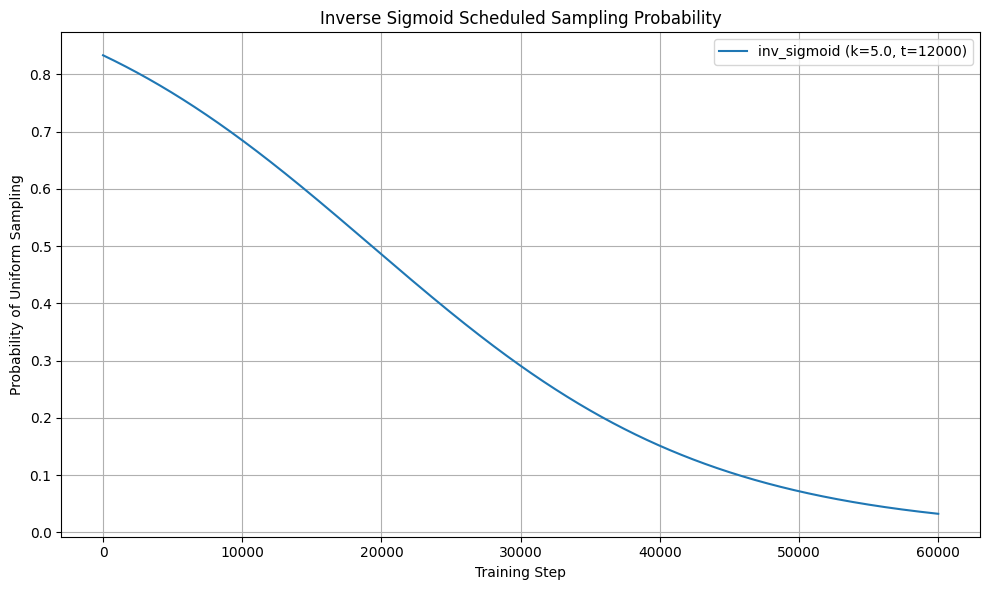

In [99]:
# Settings
total_steps = 60000
k = 5.0
t = 12000

# Generate schedule
steps = np.arange(total_steps)
probs = [sampling_schedule(s, total_steps, 'inv_sigmoid', k=k, t=t) for s in steps]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, probs, label=f'inv_sigmoid (k={k}, t={t})')
plt.title("Inverse Sigmoid Scheduled Sampling Probability")
plt.xlabel("Training Step")
plt.ylabel("Probability of Uniform Sampling")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [100]:
def orig_forward_process(input_ids, mask_prob=0.15, mask_token_id=MASK_TOKEN_ID):
    p_mask = (torch.rand_like(input_ids.float()) < mask_prob)
    noisy_input = input_ids.clone()
    noisy_input[p_mask] = mask_token_id
    return noisy_input, p_mask

def orig_forward_process(input_ids, mask_prob=0.15, mask_token_id=MASK_TOKEN_ID):
    rand = torch.rand_like(input_ids.float())  # shape: (B, L)
    p_mask = rand < mask_prob                 # uniform random masking
    noisy_input = input_ids.clone()
    noisy_input[p_mask] = mask_token_id

    sorted_indices = torch.argsort(rand, dim=1)  # token masking rank, low → high
    return noisy_input, p_mask, sorted_indices

mask_prob → avg actual masked fraction
 0.00     → 0.000
 0.05     → 0.047
 0.10     → 0.095
 0.15     → 0.148
 0.20     → 0.189
 0.25     → 0.257
 0.30     → 0.294
 0.35     → 0.342
 0.40     → 0.394
 0.45     → 0.455
 0.50     → 0.484
 0.55     → 0.561
 0.60     → 0.604
 0.65     → 0.654
 0.70     → 0.693
 0.75     → 0.740
 0.80     → 0.800
 0.85     → 0.847
 0.90     → 0.904
 0.95     → 0.949
 1.00     → 1.000


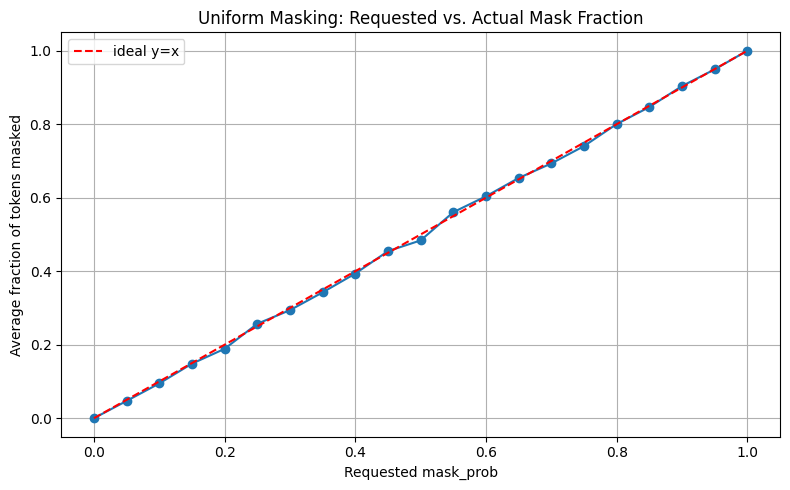

In [101]:
sentence = "The quick brown fox jumped over the lazy dog."
input_ids = tokenizer(sentence, return_tensors="pt").input_ids  # shape (L,)

mask_probs = np.linspace(0.0, 1.0, 21)  # 0.0, 0.05, ..., 1.0
estimates = []

trials = 500

for mp in mask_probs:
    masked_fracs = []
    for _ in range(trials):
        _, p_mask, _ = orig_forward_process(input_ids, mask_prob=mp)
        masked_fracs.append(p_mask.float().mean().item())
    estimates.append(np.mean(masked_fracs))

print("mask_prob → avg actual masked fraction")
for mp, frac in zip(mask_probs, estimates):
    print(f"{mp:5.2f}     → {frac:.3f}")

plt.figure(figsize=(8,5))
plt.plot(mask_probs, estimates, marker='o')
plt.plot([0,1],[0,1], 'r--', label="ideal y=x")
plt.title("Uniform Masking: Requested vs. Actual Mask Fraction")
plt.xlabel("Requested mask_prob")
plt.ylabel("Average fraction of tokens masked")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [104]:
print("\nDecoded masked sequences:")
for mp in [0.1, 0.3, 0.5, 0.8]:
    noisy_ids, p_mask, _ = orig_forward_process(input_ids, mask_prob=mp)
    decoded = tokenizer.decode(noisy_ids.squeeze(0), skip_special_tokens=False)
    print(f"\nmask_prob={mp:.2f}:")
    print(decoded)


Decoded masked sequences:

mask_prob=0.10:
The quick brown<|mdm_mask|> jumped over the lazy dog.

mask_prob=0.30:
The quick brown fox jumped over the lazy<|mdm_mask|>.

mask_prob=0.50:
<|mdm_mask|><|mdm_mask|> brown<|mdm_mask|><|mdm_mask|> over the lazy dog.

mask_prob=0.80:
The<|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|> the<|mdm_mask|> dog<|mdm_mask|>


In [41]:
def build_tokenid_to_priority(vocab_dict, rand_dict, default_priority=0.5):
    max_id = max(vocab_dict.values()) + 1
    table = np.full(max_id, default_priority)
    for (_, token_id), priority in rand_dict.items():
        table[token_id] = priority
    return table

tokenid_to_priority = build_tokenid_to_priority(vocab_dict, rand_dict)

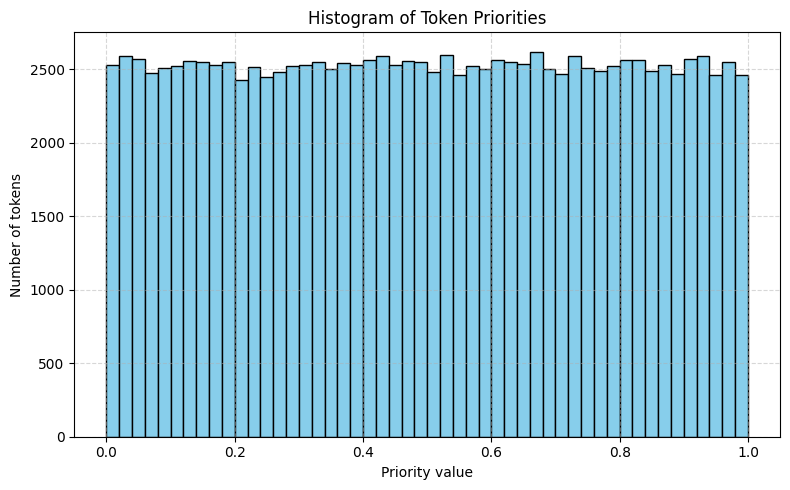

In [105]:
priorities = tokenid_to_priority[: max(vocab_dict.values()) + 1]

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(priorities, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Token Priorities")
plt.xlabel("Priority value")
plt.ylabel("Number of tokens")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [109]:
def new_forward_process(input_ids, mask_prob, tokenid_to_priority,
                        mask_token_id=MASK_TOKEN_ID, temperature=0.4, gamma=4.0):
    device = input_ids.device
    token_ids = input_ids.cpu().numpy()  # (B, L)
    priorities = tokenid_to_priority[token_ids]  # (B, L)

    use_uniform = np.random.rand() < temperature
    k = int(mask_prob * token_ids.shape[1])
    if use_uniform:
        timestamps = np.random.rand(*token_ids.shape)  # shape (B, L)
    else:
        a = 1 + gamma * priorities
        b = 1 + gamma * (1 - priorities)
        timestamps = beta.rvs(a, b, size=token_ids.shape)

    sorted_indices = np.argsort(timestamps, axis=1)  # (B, L)
    B, L = sorted_indices.shape
    row_idx = np.arange(B)[:, None]  # shape (B, 1)
    col_idx = sorted_indices[:, :k]  # shape (B, k)
    
    mask_flags = np.zeros_like(sorted_indices, dtype=bool)
    mask_flags[row_idx, col_idx] = True
        
    p_mask = torch.from_numpy(mask_flags).to(device=input_ids.device)
    noisy_input = input_ids.clone()
    noisy_input[p_mask] = mask_token_id
    return noisy_input, p_mask, sorted_indices

Token priorities:
The          → 0.110
Ġquick       → 0.698
Ġbrown       → 0.017
Ġfox         → 0.759
Ġjumped      → 0.676
Ġover        → 0.824
Ġthe         → 0.790
Ġlazy        → 0.322
Ġdog         → 0.255
.            → 0.460


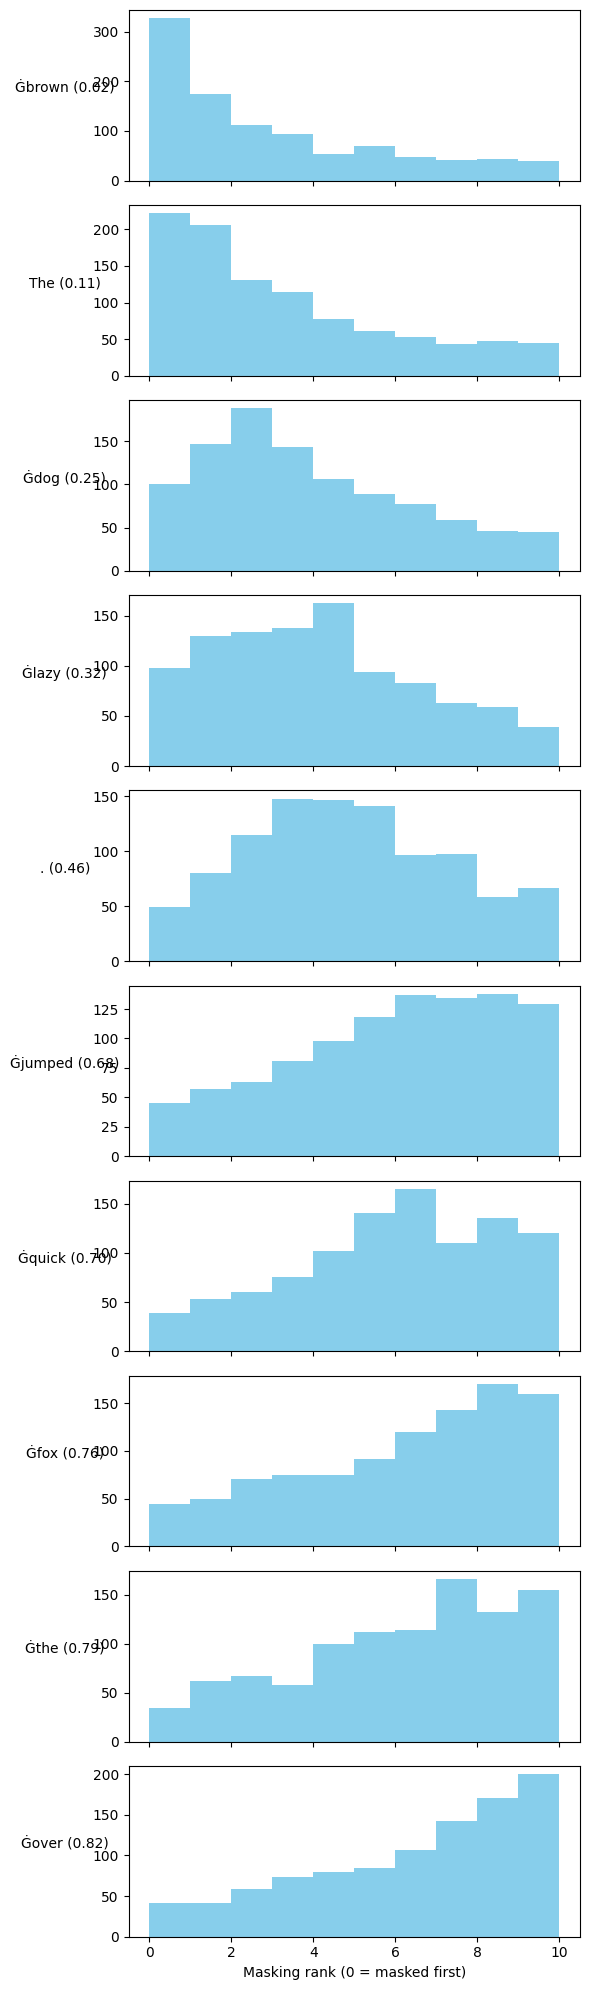


Masked sequences:
mask_prob=0.00: The quick brown fox jumped over the lazy dog.
mask_prob=0.10: The quick brown fox jumped over the lazy<|mdm_mask|>.
mask_prob=0.20: The quick<|mdm_mask|> fox jumped over the lazy<|mdm_mask|>.
mask_prob=0.30: The<|mdm_mask|><|mdm_mask|><|mdm_mask|> jumped over the lazy dog.
mask_prob=0.40: <|mdm_mask|> quick brown fox jumped<|mdm_mask|> the<|mdm_mask|><|mdm_mask|>.
mask_prob=0.50: <|mdm_mask|> quick<|mdm_mask|> fox jumped over<|mdm_mask|><|mdm_mask|><|mdm_mask|>.
mask_prob=0.60: <|mdm_mask|> quick<|mdm_mask|><|mdm_mask|> jumped over<|mdm_mask|><|mdm_mask|><|mdm_mask|>.
mask_prob=0.70: <|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|> over the<|mdm_mask|><|mdm_mask|>.
mask_prob=0.80: <|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|> jumped<|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|>.
mask_prob=0.90: <|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|>.
mask_prob=1.00: <|mdm_mask|><|md

In [110]:
sentence = "The quick brown fox jumped over the lazy dog."
inputs = tokenizer(sentence, return_tensors="pt")
input_ids = inputs.input_ids  # shape: (1, sequence_length)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Token priorities:")
for tok, tid in zip(tokens, input_ids[0].tolist()):
    print(f"{tok:12s} → {tokenid_to_priority[tid]:.3f}")

mask_prob = 0.5
step = 60000
total_steps = 60000
trials = 1000
ranks = {i: [] for i in range(len(tokens))}

for _ in range(trials):
    noisy_input, p_mask, sorted_indices = new_forward_process(input_ids, mask_prob, tokenid_to_priority, temperature=0.4)
    # sorted_idx[0] records the ranking for the single batch entry
    sorted_idx = np.argsort(sorted_indices[0])
    for pos in range(len(tokens)):
        ranks[pos].append(sorted_idx[pos])

# Get priorities for each token position
token_ids = input_ids[0].tolist()
priorities = [tokenid_to_priority[tid] for tid in token_ids]
sorted_indices = sorted(range(len(tokens)), key=lambda i: priorities[i])

# Plot in sorted priority order
fig, axes = plt.subplots(len(tokens), 1, figsize=(6, 2 * len(tokens)), sharex=True)
for plot_idx, token_idx in enumerate(sorted_indices):
    ax = axes[plot_idx]
    ax.hist(ranks[token_idx], bins=len(tokens), range=(0, len(tokens)), color='skyblue')
    label = f"{tokens[token_idx]} ({priorities[token_idx]:.2f})"
    ax.set_ylabel(label, rotation=0, labelpad=20)
axes[-1].set_xlabel("Masking rank (0 = masked first)")
plt.tight_layout()
plt.show()

def new_forward_and_mask(input_ids, mask_prob,
                         tokenid_to_priority, mask_token_id, temperature, gamma):
    device = input_ids.device
    # Ensure token_ids is 2D (batch size 1, sequence length)
    token_ids = input_ids.cpu().numpy()
    priorities = tokenid_to_priority[token_ids]
    use_uniform = np.random.rand() < temperature
    if use_uniform:
        timestamps = np.random.rand(*token_ids.shape)
    else:
        a = 1 + gamma * priorities
        b = 1 + gamma * (1 - priorities)
        timestamps = beta.rvs(a, b, size=token_ids.shape)
    k = int(mask_prob * token_ids.shape[1])
    sorted_idx = np.argsort(timestamps, axis=1)[0]
    mask = np.zeros_like(token_ids, dtype=bool)
    mask[0, sorted_idx[:k]] = True
    p_mask = torch.from_numpy(mask).to(device=input_ids.device)
    noisy = input_ids.clone()
    noisy[p_mask] = mask_token_id
    return noisy, p_mask

print("\nMasked sequences:")
for mp in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    noisy, _ = new_forward_and_mask(input_ids, mp, 
                                    tokenid_to_priority, MASK_TOKEN_ID, 0.4, 4.0)
    print(f"mask_prob={mp:.2f}: {tokenizer.decode(noisy[0])}")

print("\nAverage masking rank per token:")
for token_idx in sorted_token_indices:
    avg_rank = np.mean(ranks[token_idx])
    print(f"{tokens[token_idx]:12s} → priority={priorities[token_idx]:.3f}, avg_rank={avg_rank:.2f}")


In [111]:
def forward_process(input_ids, mask_prob, step, total_steps, tokenid_to_priority, mask_token_id=MASK_TOKEN_ID, temperature=0.3):
    p = sampling_schedule(step, total_steps)
    if np.random.rand() < p:
        #print("Original Forward Process")
        noisy_input, p_mask, sorted_indices = orig_forward_process(input_ids, mask_prob, mask_token_id=mask_token_id)
    else:
        #print("New Forward Process")
        noisy_input, p_mask, sorted_indices = new_forward_process(input_ids, mask_prob, tokenid_to_priority, mask_token_id=mask_token_id, temperature=temperature)

    return noisy_input, p_mask, sorted_indices

Token priorities:
The          → 0.110
Ġquick       → 0.698
Ġbrown       → 0.017
Ġfox         → 0.759
Ġjumped      → 0.676
Ġover        → 0.824
Ġthe         → 0.790
Ġlazy        → 0.322
Ġdog         → 0.255
.            → 0.460


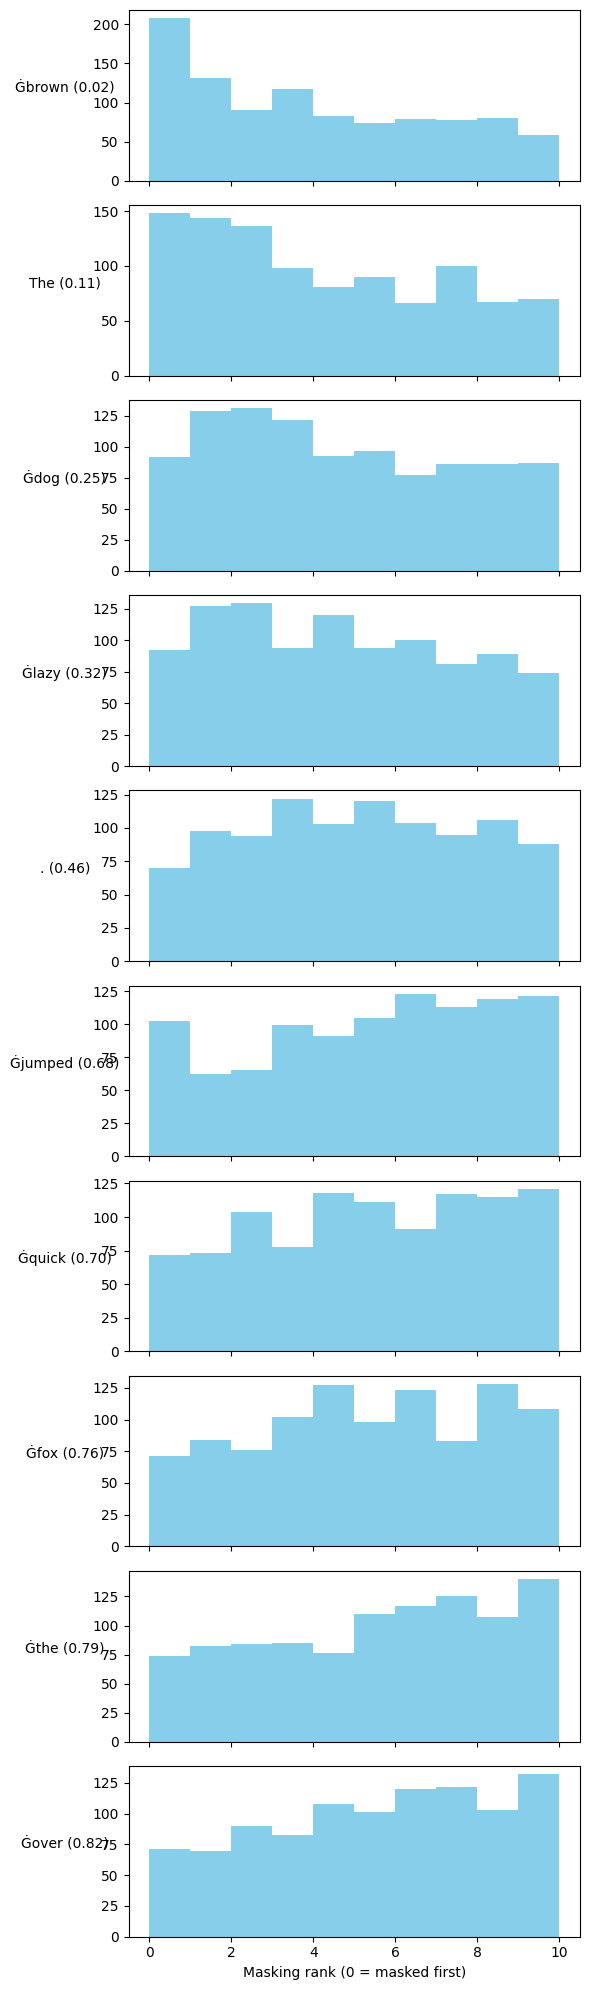


Average masking rank per token:
Ġbrown       → priority=0.017, avg_rank=3.56
The          → priority=0.110, avg_rank=3.75
Ġdog         → priority=0.255, avg_rank=4.15
Ġlazy        → priority=0.322, avg_rank=4.16
.            → priority=0.460, avg_rank=4.59
Ġjumped      → priority=0.676, avg_rank=4.95
Ġquick       → priority=0.698, avg_rank=4.92
Ġfox         → priority=0.759, avg_rank=4.86
Ġthe         → priority=0.790, avg_rank=5.05
Ġover        → priority=0.824, avg_rank=5.02


In [114]:
sentence = "The quick brown fox jumped over the lazy dog."
inputs = tokenizer(sentence, return_tensors="pt")
input_ids = inputs.input_ids  # shape: (1, sequence_length)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Token priorities:")
token_ids = input_ids[0].tolist()
priorities = [tokenid_to_priority[tid] for tid in token_ids]
for tok, tid in zip(tokens, token_ids):
    print(f"{tok:12s} → {tokenid_to_priority[tid]:.3f}")

# Collect masking ranks
mask_prob = 0.5
step = 10000
total_steps = 60000
trials = 1000
ranks = {i: [] for i in range(len(tokens))}

for _ in range(trials):
    noisy_input, p_mask, sorted_indices = forward_process(
        input_ids, mask_prob, step, total_steps,
        tokenid_to_priority, mask_token_id=MASK_TOKEN_ID, 
        temperature = 0.4
    )
    sorted_idx = np.argsort(sorted_indices[0])
    for pos in range(len(tokens)):
        ranks[pos].append(sorted_idx[pos])

# Sort tokens by priority (ascending)
sorted_token_indices = sorted(range(len(tokens)), key=lambda i: priorities[i])

# Plot per-token histograms
fig, axes = plt.subplots(len(tokens), 1, figsize=(6, 2 * len(tokens)), sharex=True)
for plot_idx, token_idx in enumerate(sorted_token_indices):
    ax = axes[plot_idx]
    ax.hist(ranks[token_idx], bins=len(tokens), range=(0, len(tokens)), color='skyblue')
    label = f"{tokens[token_idx]} ({priorities[token_idx]:.2f})"
    ax.set_ylabel(label, rotation=0, labelpad=20)
axes[-1].set_xlabel("Masking rank (0 = masked first)")
plt.tight_layout()
plt.show()

print("\nAverage masking rank per token:")
for token_idx in sorted_token_indices:
    avg_rank = np.mean(ranks[token_idx])
    print(f"{tokens[token_idx]:12s} → priority={priorities[token_idx]:.3f}, avg_rank={avg_rank:.2f}")


In [118]:
from transformers import AutoTokenizer
from wordfreq import word_frequency
threshold = 1e-6

tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Instruct", trust_remote_code=True)
llada_vocab = tokenizer.get_vocab()
llada_tokens = list(llada_vocab.keys())
print("Tokenizer vocab size:", len(llada_vocab))

Tokenizer vocab size: 126349


In [124]:
llada_tokens_cleaned = llada_tokens
real_words = [
    t for t in llada_tokens_cleaned
    if word_frequency(t, "en") > threshold or word_frequency(t[1:], "en") > threshold
]
non_words = [t for t in llada_tokens_cleaned if t not in real_words]

print(f"Total LLaDA vocab tokens       : {len(llada_tokens_cleaned)}")
print(f"Tokens recognized by wordfreq : {len(real_words)}")
print(f"Percentage of real-world words: {len(real_words) / len(llada_tokens_cleaned) * 100:.2f}%")

Total LLaDA vocab tokens       : 126349
Tokens recognized by wordfreq : 54872
Percentage of real-world words: 43.43%


In [125]:
print("\nSample real English tokens:")
print(random.sample(real_words, 50))

print("\nSample non-English/uncommon tokens:")
print(random.sample(non_words, 50))


Sample real English tokens:
['ULE', 'Ġresearchers', 'Ġauditors', '(ids', 'Ġclubhouse', 'Ġblessings', 'Ġlearning', 'Tint', 'given', '.V', 'Ġhear', 'Ġpour', '-q', 'Ġpurity', 'Collect', 'WM', 'æ¡©', 'mV', 'ĠLivingston', 'Ġif', 'ĠBenn', 'ĠUAE', 'Ġbtw', 'ĠGNU', 'Ġminimise', 'Ġreturning', 'Ġmod', 'Ġdoesn', 'Vers', '.Binary', 'ott', 'Long', 'ĠHes', 'Ġgastrointestinal', 'Ġrehabilitation', 'ĠParties', 'Theta', 'Ġmerger', 'Be', 'Ġterminals', 'Ġuniversally', 'Ġcrafty', '_REGION', 'Ġcaught', 'Ġhung', '_IR', 'Ne', 'Ġpartisan', 'ĠDecorating', 'Ġoak']

Sample non-English/uncommon tokens:
['ï¼Įä¸įæŃ¢', 'çĤ«', 'åİĭçĶµ', 'ï¼Įå¤į', 'å®ļäºİ', 'ä¾Ŀæį®', 'æ²¹æ¼Ĩ', 'æ°´ä¸ĭ', 'æľīéĻĲ', 'çĸŁ', 'å¾Īå¥½', 'ç¦ıåĪ©', 'tagHelperExecutionContext', 'åį«çĶŁéĥ¨', 'å¹´èİ·', 'å¤ªéķ¿', 'æ®ĭéª¸', 'ãĢĭè¯´', 'åĨħçļĦ', 'åıĹä¸įäºĨ', 'è¾ĥå¥½', 'ä½łçŁ¥éģĵ', 'ç«Ļåľ¨éĹ¨åı£', 'Ġcnt', 'ä¸Ģèµ·æĿ¥çľĭçľĭåĲ§', 'çĶµç«ŀ', 'é¼ĵåĲ¹', 'è¿ľ', 'åı¯ä»¥éĩĩçĶ¨', 'èµ¶èµ°', 'æĶ¿åħļ', 'Ġeigenvalue', 'åĴĮä¸į', 'çļĦéŁ³ä¹Ĳ', 'çļĦçĲĨå¿µ', 'åłĩ', 'è¿ľè¿

In [127]:
import pandas as pd
import random

# Load the Wikipedia TF-IDF dataset
idf_df = pd.read_csv("wiki_tfidf_terms.csv")
#idf_terms = set(t.lower() for t in idf_df['token'])  # lowercase all TF-IDF terms
idf_terms = set(str(t).lower() for t in idf_df['token'].dropna())

In [128]:
# Compute overlap
tokens_in_wiki = [t for t in real_words if t in idf_terms or t[1:] in idf_terms]

percent_overlap = 100 * len(tokens_in_wiki) / len(real_words)

# Output
print(f"LLaDA real English vocab tokens total        : {len(real_words)}")
print(f"Tokens found in wiki_tfidf     : {len(tokens_in_wiki)}")
print(f"Percentage of LLaDA real English vocab in wiki IDF set: {percent_overlap:.2f}%")

# Sample tokens not in Wikipedia
tokens_not_in_wiki = [t for t in real_words if t not in tokens_in_wiki]

LLaDA real English vocab tokens total        : 54872
Tokens found in wiki_tfidf     : 36446
Percentage of LLaDA real English vocab in wiki IDF set: 66.42%


In [129]:
print("\nSample of LLaDA real English vocab tokens in Wikipedia TF-IDF set:")
print(random.sample(tokens_in_wiki, 50))

print("\nSample of LLaDA real English vocab tokens NOT found in Wikipedia TF-IDF set:")
print(random.sample(tokens_not_in_wiki, 50))


Sample of LLaDA real English vocab tokens in Wikipedia TF-IDF set:
['.alpha', 'Ġthorough', 'Sus', 'Ġdepict', 'Ġgrove', 'Ġpatio', 'Ġsid', 'inherit', 'Ġsol', 'Ġventilation', 'Ġexcitement', 'western', 'ever', 'Skills', 'Ġpound', 'Ġcir', '@property', 'Ġspontaneously', 'Ġcleavage', '_compiler', 'Ġalliances', 'Ġhandle', 'Ġweaknesses', 'threat', 'Ġcyclic', 'ometh', 'Ġscratched', 'tech', 'Ġhumility', 'Wood', 'Ġillustrate', 'Ġbullied', 'Ġdivergence', 'iast', 'Nov', 'Ġouter', 'Ġblamed', 'Ġdum', 'Ġinterpretation', '-suite', 'Ġyork', 'Cert', 'Ġplantations', 'Ġdefend', 'tal', 'Ġbraking', 'Ġedit', 'town', 'Ġrestraints', 'Ġtortilla']

Sample of LLaDA real English vocab tokens NOT found in Wikipedia TF-IDF set:
['MCs', 'ĠNuts', 'Offset', 'FORM', 'ĠDue', 'DFS', 'ĠFran', 'ç§¦', 'ĠCalculation', 'à¤²', 'ĠBird', '.Form', 'ĠGift', 'Manufacturing', 'XY', '_POSITION', '_DISABLE', 'ĠRussian', '(Level', 'ĠNews', 'IGH', 'ĠMattress', 'ĠWholesale', 'ĠDip', 'ĠLeigh', 'Confirm', 'ENG', 'ĠWanted', 'ĠFish', 'ĠiPod', 

In [130]:
# Compute overlap
tokens_in_wiki = [t for t in real_words if t.lower() in idf_terms or t[1:].lower() in idf_terms]

percent_overlap = 100 * len(tokens_in_wiki) / len(real_words)

# Output
print(f"LLaDA real English vocab tokens total        : {len(real_words)}")
print(f"Tokens found in wiki_tfidf     : {len(tokens_in_wiki)}")
print(f"Percentage of LLaDA real English vocab in wiki IDF set: {percent_overlap:.2f}%")

# Sample tokens not in Wikipedia
tokens_not_in_wiki = [t for t in real_words if t not in tokens_in_wiki]

LLaDA real English vocab tokens total        : 54872
Tokens found in wiki_tfidf     : 54238
Percentage of LLaDA real English vocab in wiki IDF set: 98.84%


In [133]:
print("\nSample of LLaDA real English vocab tokens in Wikipedia TF-IDF set:")
print(random.sample(tokens_in_wiki, 100))

print("\nSample of LLaDA real English vocab tokens NOT found in Wikipedia TF-IDF set:")
print(random.sample(tokens_not_in_wiki, 50))


Sample of LLaDA real English vocab tokens in Wikipedia TF-IDF set:
['Ġelectrical', 'Ġconceive', 'ĠSIM', 'Ġper', 'Ġunrelated', 'ĠWhenever', 'Drop', 'UES', 'Ġzipper', 'ĠFORCE', 'ĠConnecting', 'Ġsuddenly', 'ĠOsborne', 'Ball', 'ĠVisits', '(date', 'Ġcrypto', 'former', '_No', 'ĠLending', 'allen', 'Ġbourbon', 'ĠShall', 'ĠAuditorium', '_package', 'Ġprinciple', 'mAh', 'ĠMortgage', 'Modify', 'Ġunrest', 'Ġgene', 'winds', 'Ġnested', '.Device', '-strong', 'Ġmost', 'ĠTone', '-term', 'NAS', 'ISHED', 'MSC', 'Ġalcoholic', 'GPS', 'ĠSL', 'Box', 'ĠColo', 'ĠAngela', 'ĠSensing', 'Take', 'ka', 'Ġdare', 'Ġmeme', 'ĠJennings', 'atie', 'Western', 'Ġinterrupt', 'Adventure', 'Ġinequalities', 'maximum', 'audit', 'ĠFreed', 'ĠHayden', 'Ġpeaches', 'Ġmental', 'Repository', 'Ġcommander', 'Ġsuite', 'ĠCommon', 'Ġreluctance', '_string', 'Ġreadership', 'Ġsnag', '(fd', 'ukin', 'after', '-reviewed', 'Ġtrapping', 'ĠHOST', 'Denied', 'ola', 'Ġpearls', 'Ġshooting', 'uits', 'Others', 'Ġagreeable', 'Ġperhaps', 'Ġmeticulous', 'ĠLin

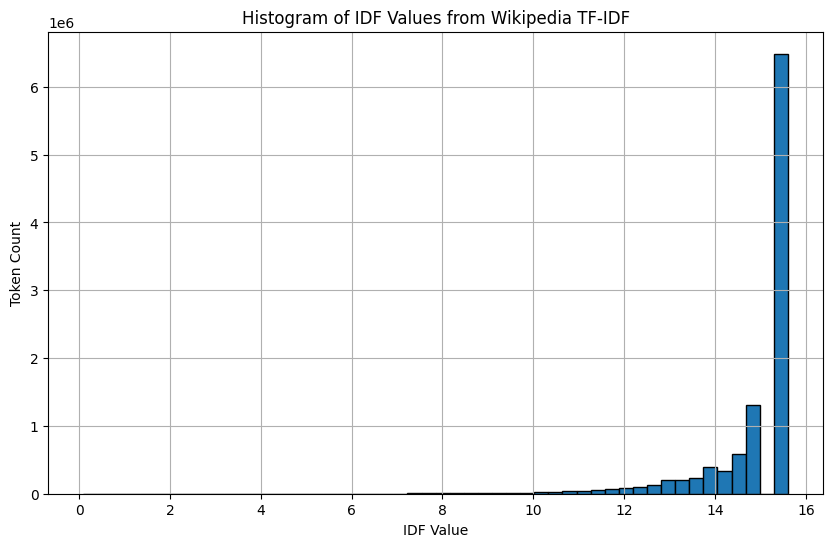

In [134]:
idf_values = idf_df['idf'].dropna()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(idf_values, bins=50, edgecolor='black')
plt.title('Histogram of IDF Values from Wikipedia TF-IDF')
plt.xlabel('IDF Value')
plt.ylabel('Token Count')
plt.grid(True)
plt.show()

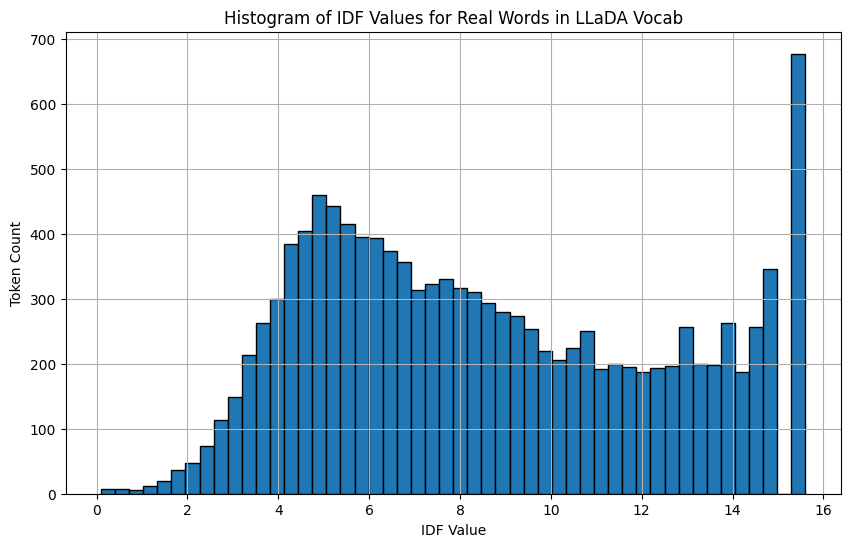

In [136]:
import matplotlib.pyplot as plt

# Normalize token text: lowercase to match your IDF vocab
real_words_lower = set(t.lower() for t in real_words)

# Filter the IDF dataframe for just the tokens in real_words
idf_real = idf_df[idf_df['token'].str.lower().isin(real_words_lower)]

# Drop NaNs in case there are any
idf_real_values = idf_real['idf'].dropna()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(idf_real_values, bins=50, edgecolor='black')
plt.title('Histogram of IDF Values for Real Words in LLaDA Vocab')
plt.xlabel('IDF Value')
plt.ylabel('Token Count')
plt.grid(True)
plt.show()


In [148]:
# Filter tokens with IDF between 7 and 8
idf_7_to_8 = idf_df[(idf_df['idf'] >= 0) & (idf_df['idf'] < 3)]

# Print how many and show a few examples
print(f"Number of tokens with 7 ≤ IDF < 8: {len(idf_7_to_8)}")
print("\nSample tokens with IDF between 7 and 8:")
print(idf_7_to_8[['token', 'idf']].sample(15).to_string(index=False))


Number of tokens with 7 ≤ IDF < 8: 405

Sample tokens with IDF between 7 and 8:
     token      idf
        17 2.918167
government 2.586093
         4 2.505231
      left 2.490989
   further 2.822767
 president 2.783408
      team 2.358911
      2008 2.590942
       one 1.222842
       and 0.262126
      road 2.999365
   started 2.618853
         6 2.667233
        up 1.762642
    though 2.857211


In [150]:
print("\nDescriptive stats for IDF values of real_words:")
print(idf_real_values.describe())


Descriptive stats for IDF values of real_words:
count    12011.000000
mean         8.634599
std          3.817906
min          0.093074
25%          5.413912
50%          7.998697
75%         11.798919
max         15.605582
Name: idf, dtype: float64


In [151]:
idf_df = idf_df.dropna(subset=['idf'])
idf_min = idf_df['idf'].min()
idf_max = idf_df['idf'].max()

# Apply min-max normalization
idf_df['idf_norm'] = (idf_df['idf'] - idf_min) / (idf_max - idf_min)

# Confirm normalization
print(f"Normalized IDF range: {idf_df['idf_norm'].min():.4f} to {idf_df['idf_norm'].max():.4f}")

Normalized IDF range: 0.0000 to 1.0000


In [155]:
idf_real_values_norm = idf_real['idf_norm'].dropna()
print(idf_real_values_norm.describe())
mean_idf_norm = idf_real_values_norm.mean()

count    12011.000000
mean         0.550622
std          0.246118
min          0.000000
25%          0.343003
50%          0.509629
75%          0.754607
max          1.000000
Name: idf_norm, dtype: float64


In [227]:
idf_dict = {
    (token, token_id): mean_idf_norm
    for token, token_id in vocab_dict.items()
}

In [160]:
idf_lookup = {
    str(row['token']): row['idf_norm']
    for _, row in idf_df.dropna(subset=['token', 'idf_norm']).iterrows()
}
print("Lookup Complete")

Lookup Complete


In [228]:
for (token, token_id), idf_val in idf_dict.items():
    if token in idf_lookup:
        idf_dict[(token, token_id)] = idf_lookup[token]

In [229]:
sampled_entries = random.sample(list(idf_dict.items()), 10)
print("Sample entries from idf_dict:")
for (token, token_id), idf_val in sampled_entries:
    print(f"Token: {token:20s} | ID: {token_id:6d} | Normalized IDF: {idf_val:.4f}")

Sample entries from idf_dict:
Token: Ġmaturation          | ID:  75700 | Normalized IDF: 0.5506
Token: ï¼ĮåĬĽæ±Ĥ            | ID:  85794 | Normalized IDF: 0.5506
Token: ĠLitigation          | ID:  62254 | Normalized IDF: 0.5506
Token: colour               | ID:  74038 | Normalized IDF: 0.3076
Token: Ġvia                 | ID:   4365 | Normalized IDF: 0.5506
Token: Ġanonymity           | ID:  74345 | Normalized IDF: 0.5506
Token: Ġgladly              | ID:  69913 | Normalized IDF: 0.5506
Token: CURRENT              | ID: 100642 | Normalized IDF: 0.5506
Token: iena                 | ID: 103939 | Normalized IDF: 0.8213
Token: éĢĨè¢Ń               | ID:  91095 | Normalized IDF: 0.5506


In [230]:
for (token, token_id), idf_val in idf_dict.items():
    if idf_val == mean_idf_norm and len(token) > 1:
        token_dropped = token[1:]
        if token_dropped in idf_lookup:
            idf_dict[(token, token_id)] = idf_lookup[token_dropped]

In [231]:
sampled_entries = random.sample(list(idf_dict.items()), 10)
print("Sample entries from idf_dict:")
for (token, token_id), idf_val in sampled_entries:
    print(f"Token: {token:20s} | ID: {token_id:6d} | Normalized IDF: {idf_val:.4f}")

Sample entries from idf_dict:
Token: ĠMagnolia            | ID: 118469 | Normalized IDF: 0.5506
Token: Ġcriticize           | ID:  81644 | Normalized IDF: 0.4475
Token: çīĽä»Ķè£¤            | ID:  60188 | Normalized IDF: 0.5506
Token: ï¼Įè¶ħçº§            | ID: 124233 | Normalized IDF: 0.5506
Token: åľŁåľ°çļĦ            | ID: 117009 | Normalized IDF: 0.5506
Token: å¹³æķ´               | ID:  45730 | Normalized IDF: 0.5506
Token: å¤§å¤§               | ID:  19006 | Normalized IDF: 0.5506
Token: äºĨä¸Ģèº«            | ID: 107443 | Normalized IDF: 0.5506
Token: æŃ£è§ĦçļĦ            | ID:  55584 | Normalized IDF: 0.5506
Token: ĠDefaults            | ID:  57565 | Normalized IDF: 0.5506


In [232]:
non_default_count = sum(
    1 for v in idf_dict.values() if v != mean_idf_norm
)
total_count = len(idf_dict)
coverage = 100 * non_default_count / total_count

print(f"Total entries         : {total_count}")
print(f"Non-default entries   : {non_default_count}")
print(f"Default entries       : {total_count - non_default_count}")
print(f"Coverage              : {coverage:.2f}%")


Total entries         : 126349
Non-default entries   : 46894
Default entries       : 79455
Coverage              : 37.11%


In [233]:
for (token, token_id), idf_val in idf_dict.items():
    if idf_val == mean_idf_norm:
        token_lower = token.lower()
        if token_lower in idf_lookup:
            idf_dict[(token, token_id)] = idf_lookup[token_lower]

for (token, token_id), idf_val in idf_dict.items():
    if idf_val == mean_idf_norm and len(token) > 1:
        token_dropped_lower = token[1:].lower()
        if token_dropped_lower in idf_lookup:
            idf_dict[(token, token_id)] = idf_lookup[token_dropped_lower]

In [234]:
non_default_count = sum(
    1 for v in idf_dict.values() if v != mean_idf_norm
)
total_count = len(idf_dict)
coverage = 100 * non_default_count / total_count

print(f"Total entries         : {total_count}")
print(f"Non-default entries   : {non_default_count}")
print(f"Default entries       : {total_count - non_default_count}")
print(f"Coverage              : {coverage:.2f}%")

Total entries         : 126349
Non-default entries   : 68566
Default entries       : 57783
Coverage              : 54.27%


Token priorities:
The          → 0.067
Ġquick       → 0.325
Ġbrown       → 0.239
Ġfox         → 0.294
Ġjumped      → 0.388
Ġover        → 0.104
Ġthe         → 0.000
Ġlazy        → 0.447
Ġdog         → 0.314
Ġand         → 0.011
Ġate         → 0.432
ĠAustin      → 0.325
's           → 0.047
Ġpussy       → 0.544
Ġcat         → 0.348
Ġalive       → 0.307
.            → 0.551


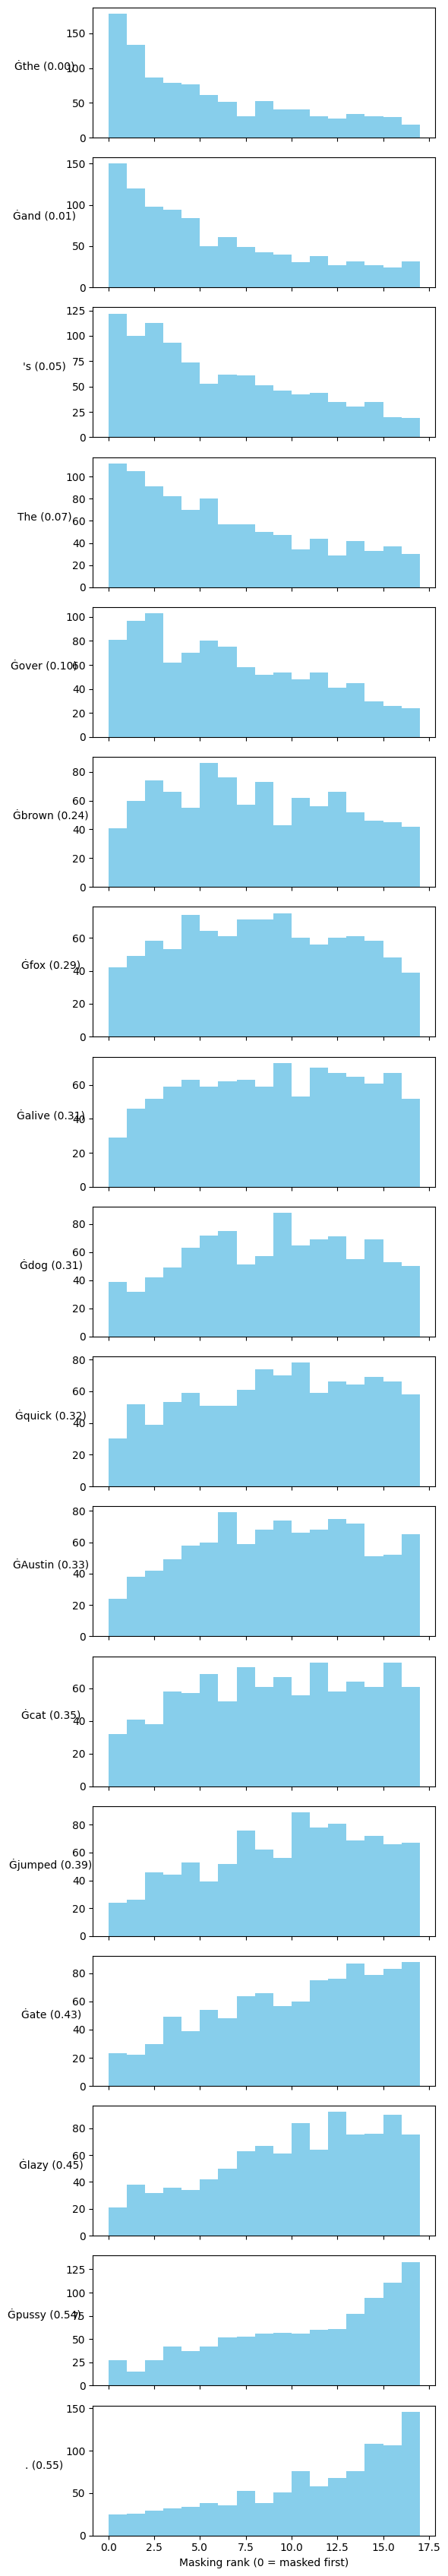


Masked sequences:
mask_prob=0.00: The quick brown fox jumped over the lazy dog and ate Austin's pussy cat alive.
mask_prob=0.10: The quick brown fox jumped over the lazy dog and ate Austin<|mdm_mask|> pussy cat alive.
mask_prob=0.20: The quick brown<|mdm_mask|> jumped over the<|mdm_mask|><|mdm_mask|> and ate Austin's pussy cat alive.
mask_prob=0.30: <|mdm_mask|> quick brown fox<|mdm_mask|> over the<|mdm_mask|><|mdm_mask|><|mdm_mask|> ate Austin's pussy cat alive.
mask_prob=0.40: <|mdm_mask|> quick brown fox jumped<|mdm_mask|> the<|mdm_mask|><|mdm_mask|> and ate Austin<|mdm_mask|> pussy<|mdm_mask|> alive.
mask_prob=0.50: <|mdm_mask|> quick<|mdm_mask|><|mdm_mask|> jumped over<|mdm_mask|><|mdm_mask|><|mdm_mask|> and<|mdm_mask|> Austin's pussy cat<|mdm_mask|>.
mask_prob=0.60: <|mdm_mask|><|mdm_mask|><|mdm_mask|> fox jumped<|mdm_mask|><|mdm_mask|> lazy<|mdm_mask|><|mdm_mask|> ate<|mdm_mask|><|mdm_mask|> pussy cat<|mdm_mask|>.
mask_prob=0.70: <|mdm_mask|> quick brown<|mdm_mask|><|mdm_mask|>

In [240]:
sentence = "The quick brown fox jumped over the lazy dog and ate Austin's pussy cat alive."
inputs = tokenizer(sentence, return_tensors="pt")
input_ids = inputs.input_ids  # shape: (1, sequence_length)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokenid_to_priority = build_tokenid_to_priority(vocab_dict, idf_dict)

print("Token priorities:")
for tok, tid in zip(tokens, input_ids[0].tolist()):
    print(f"{tok:12s} → {tokenid_to_priority[tid]:.3f}")

mask_prob = 0.5
step = 60000
total_steps = 60000
trials = 1000
ranks = {i: [] for i in range(len(tokens))}

for _ in range(trials):
    noisy_input, p_mask, sorted_indices = new_forward_process(input_ids, mask_prob, tokenid_to_priority, temperature=0.4)
    # sorted_idx[0] records the ranking for the single batch entry
    sorted_idx = np.argsort(sorted_indices[0])
    for pos in range(len(tokens)):
        ranks[pos].append(sorted_idx[pos])

# Get priorities for each token position
token_ids = input_ids[0].tolist()
priorities = [tokenid_to_priority[tid] for tid in token_ids]
sorted_indices = sorted(range(len(tokens)), key=lambda i: priorities[i])

# Plot in sorted priority order
fig, axes = plt.subplots(len(tokens), 1, figsize=(6, 2 * len(tokens)), sharex=True)
for plot_idx, token_idx in enumerate(sorted_indices):
    ax = axes[plot_idx]
    ax.hist(ranks[token_idx], bins=len(tokens), range=(0, len(tokens)), color='skyblue')
    label = f"{tokens[token_idx]} ({priorities[token_idx]:.2f})"
    ax.set_ylabel(label, rotation=0, labelpad=20)
axes[-1].set_xlabel("Masking rank (0 = masked first)")
plt.tight_layout()
plt.show()

def new_forward_and_mask(input_ids, mask_prob,
                         tokenid_to_priority, mask_token_id, temperature, gamma):
    device = input_ids.device
    # Ensure token_ids is 2D (batch size 1, sequence length)
    token_ids = input_ids.cpu().numpy()
    priorities = tokenid_to_priority[token_ids]
    use_uniform = np.random.rand() < temperature
    if use_uniform:
        timestamps = np.random.rand(*token_ids.shape)
    else:
        a = 1 + gamma * priorities
        b = 1 + gamma * (1 - priorities)
        timestamps = beta.rvs(a, b, size=token_ids.shape)
    k = int(mask_prob * token_ids.shape[1])
    sorted_idx = np.argsort(timestamps, axis=1)[0]
    mask = np.zeros_like(token_ids, dtype=bool)
    mask[0, sorted_idx[:k]] = True
    p_mask = torch.from_numpy(mask).to(device=input_ids.device)
    noisy = input_ids.clone()
    noisy[p_mask] = mask_token_id
    return noisy, p_mask

print("\nMasked sequences:")
for mp in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    noisy, _ = new_forward_and_mask(input_ids, mp, 
                                    tokenid_to_priority, MASK_TOKEN_ID, 0.4, 4.0)
    print(f"mask_prob={mp:.2f}: {tokenizer.decode(noisy[0])}")

print("\nAverage masking rank per token:")
for token_idx in sorted_token_indices:
    avg_rank = np.mean(ranks[token_idx])
    print(f"{tokens[token_idx]:12s} → priority={priorities[token_idx]:.3f}, avg_rank={avg_rank:.2f}")
